In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [2]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tools.eval_measures import meanabs, rmse
from statsmodels.tsa.stattools import adfuller,kpss

In [3]:
def invert_difference(data,residual):
    ind = data.index.get_loc(residual.index[0])
    if ind > 0:
        length = len(residual)
        vals = np.array(data.iloc[ind-1:ind-1+length]) + np.array(residual)
    else:
        residual = residual[1:]
        length = len(residual)
        vals = np.array(data.iloc[ind:ind+length]) + np.array(residual)
    result = pd.Series(vals,index=residual.index)
    return result

In [4]:
path = 'data/slv_working.pkl'
with open(path, 'rb') as f:
    slv_clean = pickle.load(f)
slv_clean.dropna(inplace=True)

In [418]:
weekly=slv_clean.resample('W').last()
weekly['pct_change'] = 100*weekly['Close'].pct_change()
weekly.dropna(inplace=True)

In [420]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 806 entries, 2006-05-07 to 2021-10-10
Freq: W-SUN
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Day         806 non-null    int64  
 1   Open        806 non-null    float64
 2   Low         806 non-null    float64
 3   High        806 non-null    float64
 4   Close       806 non-null    float64
 5   Volume      806 non-null    int64  
 6   pct_change  806 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 50.4 KB


**To model, we split the data into training and test sets. We use the first 80% of the data as the training set.**

In [137]:
metrics = []
for d in range(3):
    for p in range(7):
        for q in range(6):
            try:
                model = ARIMA(train_resid,order=(p,d,q),trend='n')
                result = model.fit()
                metrics.append((p,d,q,result.aic,result.bic))
            except:
                pass
metr_diff = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_diff.sort_values('AIC').head()

,p,d,q,AIC,BIC
32,5,0,2,1842.984056,1878.738059
38,6,0,2,1844.683292,1884.906545
39,6,0,3,1846.903419,1891.595922
82,6,1,4,1853.805275,1902.949961
83,6,1,5,1856.086493,1909.698877


In [138]:
metr_diff.sort_values('BIC').head()

,p,d,q,AIC,BIC
32,5,0,2,1842.984056,1878.738059
0,0,0,0,1877.127598,1881.596848
3,0,0,3,1863.960886,1881.837888
18,3,0,0,1865.960770,1883.837772
38,6,0,2,1844.683292,1884.906545


In [139]:
model = ARIMA(train_resid,order=(5,0,2),trend='n')
arma502 = model.fit()
print(arma502.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  645
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -913.492
Date:                Mon, 06 Dec 2021   AIC                           1842.984
Time:                        19:31:28   BIC                           1878.738
Sample:                    05-07-2006   HQIC                          1856.857
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2647      0.049      5.398      0.000       0.169       0.361
ar.L2         -0.8804      0.040    -21.772      0.000      -0.960      -0.801
ar.L3         -0.1103      0.048     -2.288      0.0

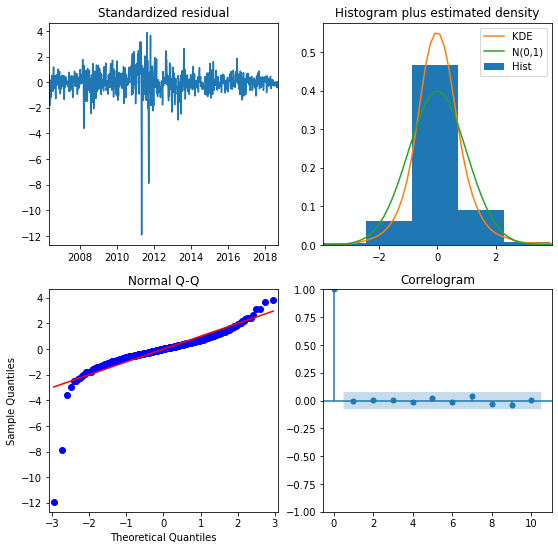

In [71]:
arma502.plot_diagnostics(figsize=(9,9))
plt.show()

In [61]:
metrics = []
d = 0
D = 0
for p in range(6):
    for q in range(3):
        for s in range(4):
            for P in range(6):
                for Q in range(3):
                    try:
                        model = ARIMA(train,order=(p,d,q),seasonal_order=(P,D,Q,s),trend='n')
                        result = model.fit()
                        metrics.append((p,d,q,P,D,Q,s,result.aic,result.bic))
                    except:
                        pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','P','D','Q','s','AIC','BIC'])
metr_resid.sort_values('AIC').head()

,p,d,q,P,D,Q,s,AIC,BIC
4,5,0,2,0,0,2,3,1840.540848,1885.217835
0,5,0,2,0,0,0,0,1841.151765,1876.893355
1,5,0,2,0,0,0,2,1841.151765,1876.893355
2,5,0,2,0,0,0,3,1841.151765,1876.893355
3,5,0,2,0,0,1,3,1846.743544,1886.952832


In [5]:
data = slv_clean['Close'].resample('W').last().diff().dropna()
train_ratio = 0.8
split = round(train_ratio * len(data))
train = data[0:split]
model = ARIMA(train,order=(5,0,2),trend='n')
arma502 = model.fit()
arma502.summary()

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  644
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -912.576
Date:                Mon, 20 Dec 2021   AIC                           1841.152
Time:                        09:58:41   BIC                           1876.893
Sample:                    05-14-2006   HQIC                          1855.021
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2647      0.049      5.390      0.000       0.168       0.361
ar.L2         -0.8804      0.040    -21.741      0.000      -0.960      -0.801
ar.L3         -0.1103      0.048     -2.285      0.022      -0.205      -0.016
ar.L4          0.0771      0.030      2.555      0.011       0.018       0.136
ar.L5         -0.2311      0.035     -6.645      0.000      -0.299      -0.163
ma.L1         -0.2117      0.038     -5.630      0.000      -0.285      -0.138
ma.L2          0.9109      0.035     25.854      0.000       0.842       0.980
sigma2         0.9951      0.025     39.244      0.000       0.945       1.045
===================================================================================
Ljung-Box (Q):                       60.08   Jarque-Bera (JB):             37668.62
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -3.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
from arch import arch_model

In [36]:
residual = arma502.resid
metrics = []
for p in range(6):
    for q in range(6):
        try:
            gmodel = arch_model(residual,p=p,q=q,mean='Constant',vol='GARCH',dist='skewt')
            gresult = gmodel.fit(disp='off')
            metrics.append((p,q,'yes',gresult.aic,gresult.bic))
        except:
            pass
for p in range(6):
    for q in range(6):
        try:
            gmodel = arch_model(residual,p=p,q=q,mean='Constant',vol='GARCH',dist='t')
            gresult = gmodel.fit(disp='off')
            metrics.append((p,q,'no',gresult.aic,gresult.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','q','skew','AIC','BIC'])
metr_resid.sort_values('AIC').head(6)

,p,q,skew,AIC,BIC
44,3,2,no,1453.476372,1489.217962
31,1,1,no,1453.994661,1476.333155
43,3,1,no,1454.314219,1485.588110
50,4,2,no,1454.666367,1494.875656
37,2,1,no,1455.213478,1482.019671
14,3,2,yes,1455.293331,1495.502619


In [37]:
gmodel = arch_model(residual,p=3,q=2,mean='Constant',vol='GARCH',dist='t')
vol_arma502 = gmodel.fit(disp='off')
vol_arma502.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -718.738
Distribution:      Standardized Student's t   AIC:                           1453.48
Method:                  Maximum Likelihood   BIC:                           1489.22
                                              No. Observations:                  644
Date:                      Mon, Dec 20 2021   Df Residuals:                      643
Time:                              12:15:53   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0124  2.640e-02     -0.470      0.638 [-6.415e-02,3.932e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0122  9.771e-03      1.249      0.212 [-6.943e-03,3.136e-02]
alpha[1]       0.0456  4.190e-02      1.089      0.276   [-3.647e-02,  0.128]
alpha[2]       0.0187  7.386e-02      0.253      0.800      [ -0.126,  0.163]
alpha[3]       0.1313  6.346e-02      2.070  3.846e-02    [6.976e-03,  0.256]
beta[1]    1.0608e-10  5.165e-02  2.054e-09      1.000      [ -0.101,  0.101]
beta[2]        0.7971  5.205e-02     15.314  6.183e-53      [  0.695,  0.899]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.4651      1.705      3.791  1.498e-04 [  3.123,  9.807]
========================================================================

Covariance estimator: robust
"""

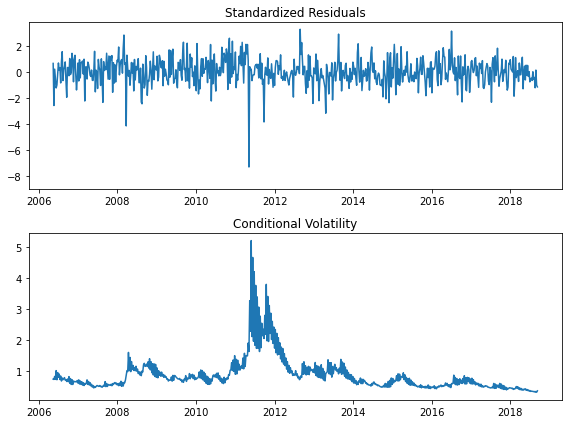

In [38]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(vol_arma502.std_resid)
ax1.set_ylim(-9,3.8)
ax1.set_title('Standardized Residuals')
ax2.plot(vol_arma502.conditional_volatility)
ax2.set_title('Conditional Volatility')
fig.tight_layout()

In [24]:
vol_forecast=vol_arma502.forecast(horizon=1,reindex=True).

In [42]:
vol_arma502.forecast(horizon=2,reindex=False).mean

,h.1,h.2
Date,,
2018-09-09,-0.012415,-0.012415


In [47]:
pred=arma502.get_prediction(-1)

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


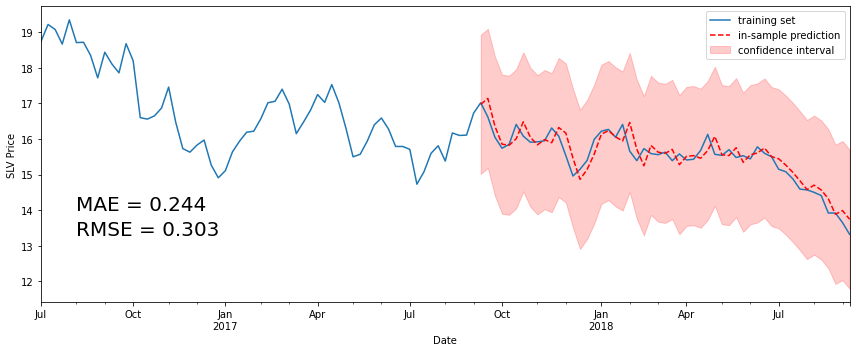

In [165]:
model = ARIMA(train,order=(5,0,2),trend='n')
arma502 = model.fit()
pred502 = arma502.get_prediction(start=-53,dynamic=False)
pred502_mean = pred502.predicted_mean
prediction502 = invert_difference(slv_train,pred502_mean)
pred502_ci = pred502.conf_int()
pred502_ll = pred502_ci.loc[:,'lower Close']
pred502_ul = pred502_ci.loc[:,'upper Close']
pred_ll = invert_difference(slv_train,pred502_ll)
pred_ul = invert_difference(slv_train,pred502_ul)

fig, ax = plt.subplots(1,1,figsize=(12,5))
slv_train['2016-07-01':].plot(label='training set')
prediction502.plot(color='red',linestyle='--',label='in-sample prediction')
mae502 = meanabs(slv_train['2017-09-10':'2018-09-09'],prediction502['2017-09-10':'2018-09-09'])
rmse502 = rmse(slv_train['2017-09-10':'2018-09-09'],prediction502['2017-09-10':'2018-09-09'])
ax.set_xlabel('Date')
ax.set_ylabel('SLV Price')
ax.text(datetime.date(2016,8,1),14,f'MAE = {mae502:.3f}',fontsize=20)
ax.text(datetime.date(2016,8,1),13,f'RMSE = {rmse502:.3f}',fontsize=20)
ax.fill_between(pred_ll.index, pred_ll, pred_ul, color='red',alpha=0.2,label='confidence interval')
plt.legend(loc='best')
fig.tight_layout()

In [360]:
train_slv, test_slv = weekly.Close[0:split], weekly.Close[split:]

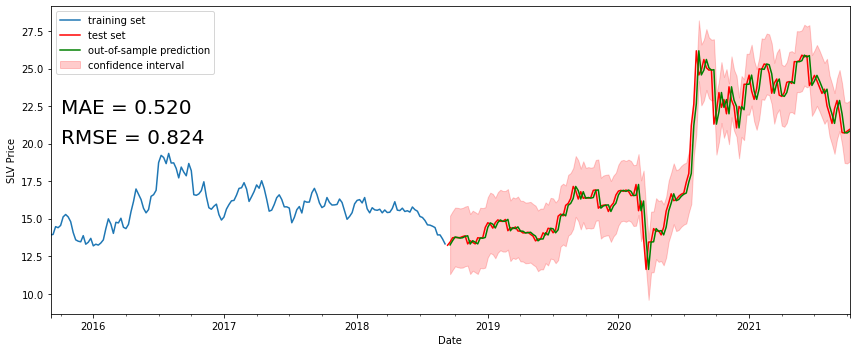

In [408]:
rtest502 = arma502.get_prediction(start=test_slv.index[0],end=test_slv.index[-1])
rtest502_mean = rtest502.predicted_mean
pred_test502 = invert_difference(test_slv,rtest502_mean)
mae_test502 = meanabs(test_slv['2018-09-23':'2021-10-10'],pred_test502['2018-09-23':'2021-10-10'])
rmse_test502 = rmse(test_slv['2018-09-23':'2021-10-10'],pred_test502['2018-09-23':'2021-10-10'])

rtest502_ci = rtest502.conf_int()
rtest502_ll = rtest502_ci.loc[:,'lower Close']
rtest502_ul = rtest502_ci.loc[:,'upper Close']
pred_ll = invert_difference(test_slv,rtest502_ll)
pred_ul = invert_difference(test_slv,rtest502_ul)


fig, ax = plt.subplots(1,1,figsize=(12,5))
xmin = datetime.date(2015,9,1)
xmax = datetime.date(2021,10,10)
ax.set_xlim(xmin,xmax)
train_slv['2015-09-01':].plot(label='training set')
test_slv.plot(color='red',label='test set')
pred_test502.plot(color='green',label='out-of-sample prediction')
ax.fill_between(pred_ll.index, pred_ll, pred_ul, color='red',alpha=0.2,label='confidence interval')
ax.set_xlabel('Date')
ax.set_ylabel('SLV Price')
ax.text(datetime.date(2015,10,1),22,f'MAE = {mae_test502:.3f}',fontsize=20)
ax.text(datetime.date(2015,10,1),20,f'RMSE = {rmse_test502:.3f}',fontsize=20)
plt.legend(loc='best')
fig.tight_layout()

In [403]:
pred_test502

2018-09-23    13.253689
2018-09-30    13.535344
2018-10-07    13.781299
2018-10-14    13.746388
2018-10-21    13.706002
                ...    
2021-09-19    21.990004
2021-09-26    20.739978
2021-10-03    20.709993
2021-10-10    20.830019
2021-10-17    20.950009
Freq: W-SUN, Length: 161, dtype: float64